In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

DATA_PATH_PREFIX = 'data_'
SAMPLED_DATA_PATH = 'sampled_coe_dfs'
PAIRS = ['BTC_USD', 'BTC_USDT', 'ETH_USD', 'ETH_USDT', 'ETH_BTC']

In [2]:
from typing import Dict, List, Tuple


def get_coe_dfs(
    path: str, method: str,
) -> Dict[int, List[pd.DataFrame]]:
    method_path = os.path.join(path, method)

    bi_level_coe_dfs = dict()
    for file in os.listdir(method_path):
        if file.endswith('.csv'):
            bi_level = int(file.split('_BI')[1].split('.')[0])
            df = pd.read_csv(os.path.join(method_path, file))

            if bi_level not in bi_level_coe_dfs:
                bi_level_coe_dfs[bi_level] = []

            bi_level_coe_dfs[bi_level].append(df)

    return bi_level_coe_dfs

def get_sampled_coe_dfs_folder(
    data_path_prefix: str, pair: str, sampled_folder: str
) -> str:
    return os.path.join(data_path_prefix + pair, sampled_folder)

def get_correlations_for_pair(
    data_path_prefix: str, pair: str, sampled_folder: str, method: str, bi_level: int
) -> List[float]:
    sampled_folder = get_sampled_coe_dfs_folder(DATA_PATH_PREFIX, pair, SAMPLED_DATA_PATH)

    bi_level_dfs_map = get_coe_dfs(sampled_folder, method)
    dfs = bi_level_dfs_map[bi_level]

    corrs = []
    for df in dfs:
        df['BaseImbalance'].corr(df['Return'])
        corrs.append(df['BaseImbalance'].corr(df['Return']))

    return corrs

def get_correlations_for_pair_all_bi_levels(
    data_path_prefix: str, pair: str, sampled_folder: str, method: str
) -> Dict[int, List[float]]:
    sampled_folder = get_sampled_coe_dfs_folder(DATA_PATH_PREFIX, pair, SAMPLED_DATA_PATH)

    bi_level_dfs_map = get_coe_dfs(sampled_folder, method)

    bi_level_corrs = dict()
    for bi_level, dfs in bi_level_dfs_map.items():
        corrs = []
        for df in dfs:
            df['BaseImbalance'].corr(df['Return'])
            corrs.append(df['BaseImbalance'].corr(df['Return']))

        bi_level_corrs[bi_level] = corrs

    return bi_level_corrs

def get_correlations_for_pairs(
    data_path_prefix: str, pairs: List[str], sampled_folder: str, method: str
) -> Dict[str, Dict[int, List[float]]]:
    corrs = dict()
    for pair in pairs:
        corrs[pair] = get_correlations_for_pair_all_bi_levels(data_path_prefix, pair, sampled_folder, method)

    return corrs

def get_correlations_for_pairs_as_df(
    data_path_prefix: str, pairs: List[str], sampled_folder: str, method: str
) -> pd.DataFrame:
    corrs = get_correlations_for_pairs(data_path_prefix, pairs, sampled_folder, method)

    dfs = []
    for pair, bi_level_corrs in corrs.items():
        for bi_level, corr in bi_level_corrs.items():
            for c in corr:
                dfs.append({
                    'Pair': pair,
                    'Base Imbalance Level': bi_level,
                    'Correlation': c
                })

    return pd.DataFrame(dfs)

def get_row_number_for_train_test_dfs_for_pair(
    data_path_prefix: str, pair: str, sampled_folder: str, method: str, bi_level: int
) -> Tuple[List[int], List[int]]:
    sampled_folder = get_sampled_coe_dfs_folder(DATA_PATH_PREFIX, pair, SAMPLED_DATA_PATH)

    bi_level_dfs_map = get_coe_dfs(sampled_folder, method)
    dfs = bi_level_dfs_map[bi_level]

    return [df[df['Timestamp'] < 1800].shape[0] for df in dfs], [df[df['Timestamp'] >= 1800].shape[0] for df in dfs]

def get_row_number_for_train_test_dfs_for_pair_all_bi_levels(
    data_path_prefix: str, pair: str, sampled_folder: str, method: str
) -> Dict[int, Tuple[List[int], List[int]]]:
    sampled_folder = get_sampled_coe_dfs_folder(DATA_PATH_PREFIX, pair, SAMPLED_DATA_PATH)

    bi_level_dfs_map = get_coe_dfs(sampled_folder, method)

    bi_level_rows = dict()
    for bi_level, dfs in bi_level_dfs_map.items():
        bi_level_rows[bi_level] = [df[df['Timestamp'] < 1800].shape[0] for df in dfs], [df[df['Timestamp'] >= 1800].shape[0] for df in dfs]

    return bi_level_rows

def get_row_number_for_train_test_dfs_for_pairs(
    data_path_prefix: str, pairs: List[str], sampled_folder: str, method: str
) -> Dict[str, Dict[int, Tuple[List[int], List[int]]]]:
    rows = dict()
    for pair in pairs:
        rows[pair] = get_row_number_for_train_test_dfs_for_pair_all_bi_levels(data_path_prefix, pair, sampled_folder, method)

    return rows

def get_row_number_for_train_test_dfs_for_pairs_as_df(
    data_path_prefix: str, pairs: List[str], sampled_folder: str, method: str
) -> pd.DataFrame:
    rows = get_row_number_for_train_test_dfs_for_pairs(data_path_prefix, pairs, sampled_folder, method)

    dfs = []
    for pair, bi_level_rows in rows.items():
        for bi_level, row in bi_level_rows.items():
            for train, test in zip(row[0], row[1]):
                dfs.append({
                    'Pair': pair,
                    'Base Imbalance Level': bi_level,
                    'Train Rows': train,
                    'Test Rows': test
                })

    return pd.DataFrame(dfs)

In [44]:
corrs_df = get_correlations_for_pairs_as_df(DATA_PATH_PREFIX, PAIRS, SAMPLED_DATA_PATH, 'oracle')
corrs_df['Correlation'] = -corrs_df['Correlation']

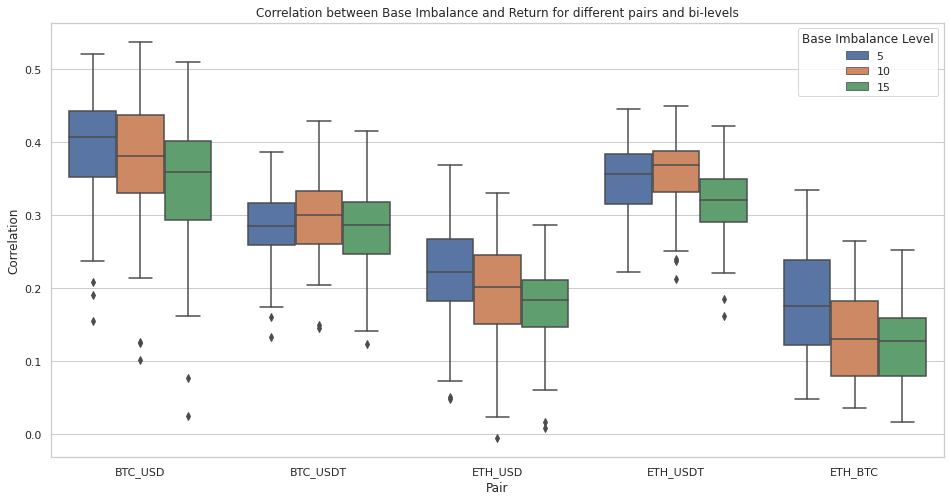

In [45]:
# produce boxplot with x-axis as pair, y-axis as correlation, and hue as bi-level
sns.set_theme(style='whitegrid')
plt.figure(figsize=(16, 8))
sns.boxplot(x='Pair', y='Correlation', hue='Base Imbalance Level', data=corrs_df)
plt.title('Correlation between Base Imbalance and Return for different pairs and bi-levels')
plt.show()


In [49]:
row_number_df = get_row_number_for_train_test_dfs_for_pairs_as_df(DATA_PATH_PREFIX, PAIRS, SAMPLED_DATA_PATH, 'oracle')
row_number_df.head()

,Pair,Base Imbalance Level,Train Rows,Test Rows
0,BTC_USD,10,1916,97
1,BTC_USD,10,2896,106
2,BTC_USD,10,1391,88
3,BTC_USD,10,1243,83
4,BTC_USD,10,3047,102


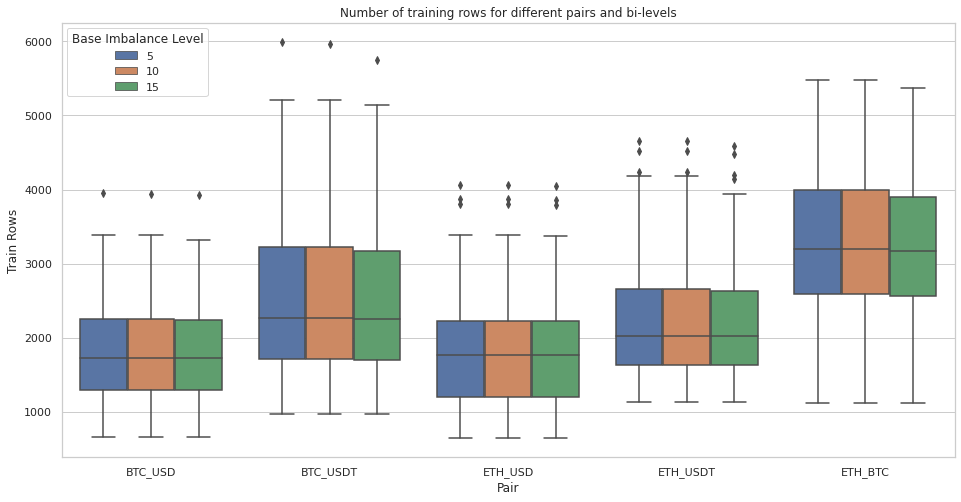

In [50]:
# produce boxplot with x-axis as pair, y-axis as row number, and hue as bi-level
sns.set_theme(style='whitegrid')
plt.figure(figsize=(16, 8))
sns.boxplot(x='Pair', y='Train Rows', hue='Base Imbalance Level', data=row_number_df)
plt.title('Number of training rows for different pairs and bi-levels')
plt.show()

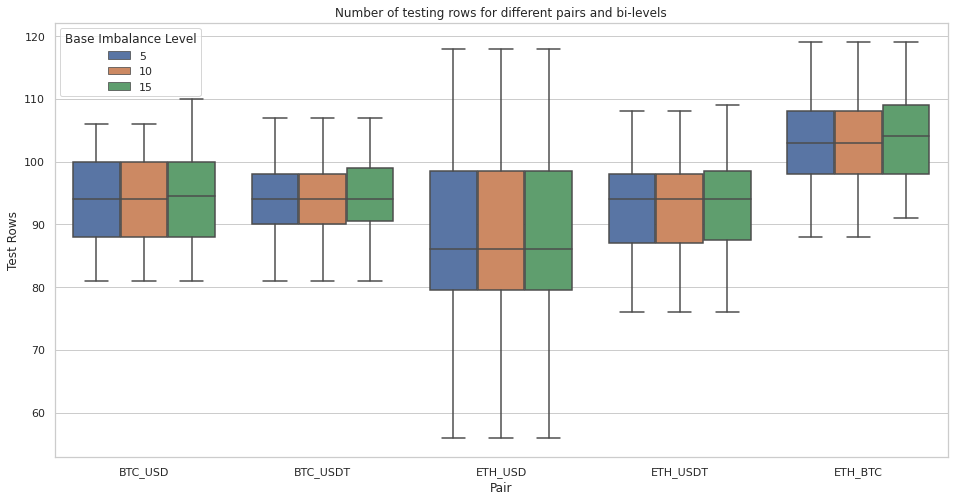

In [51]:
# produce boxplot with x-axis as pair, y-axis as row number, and hue as bi-level
sns.set_theme(style='whitegrid')
plt.figure(figsize=(16, 8))
sns.boxplot(x='Pair', y='Test Rows', hue='Base Imbalance Level', data=row_number_df)
plt.title('Number of testing rows for different pairs and bi-levels')
plt.show()

In [3]:
def read_orderbook_df(file_path: str, bi: int) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep='\t')
    df['MidPrice'] = (df["AskPrice1"]+df["BidPrice1"])/2
    df['Return'] = (-df["MidPrice"]+df["MidPrice"].shift(-1)) / df["MidPrice"]

    pbid = df["BidPrice1"] - df[f"BidPrice{bi}"]
    pask = df[f"AskPrice{bi}"] - df["AskPrice1"]
    df["BaseImbalance"] = (pbid-pask)/(pbid+pask)

    df=df.dropna(subset=['Return', 'BaseImbalance'])
    df = df[df['Return'] != 0]
    df = df[['Timestamp', 'BaseImbalance', 'Return']]
    df['Diff'] = df['Timestamp'].diff()

    return df


In [16]:
coe_df_file_path = 'data_ETH_BTC/sampled_coe_dfs/oracle/1713886484276_1713882764_BI10.csv'
ob_file_path = '/home/davide/Desktop/phd/bitfinex-api-py/data/ETH_BTC/orderbook_changes/orderbook_changes_1713886484276.tsv'
coe_df = pd.read_csv(coe_df_file_path)
ob_df = read_orderbook_df(ob_file_path, bi=10)
ob_df['TimestampScaled'] = (ob_df['Timestamp'] / 1000) - (1713882764 - 1800)
ob_df['TimestampScaled'] = ob_df['TimestampScaled'].round(3)
ob_df.head()

,Timestamp,BaseImbalance,Return,Diff,TimestampScaled
0,1713879284000,-0.022222,-0.000021,NaN,-1680.000
1,1713879284179,-0.043478,-0.000052,179.0,-1679.821
2,1713879284380,-0.100000,-0.000052,201.0,-1679.620
3,1713879284681,-0.354839,-0.000010,301.0,-1679.319
4,1713879284682,-0.230769,-0.000010,1.0,-1679.318


In [21]:
ob_df_filtered_train = ob_df[(ob_df['TimestampScaled'] >= 0) & (ob_df['TimestampScaled'] <= 1800)]
ob_df_filtered_train.head()

,Timestamp,BaseImbalance,Return,Diff,TimestampScaled
8658,1713880964182,-0.064516,0.000041,547.0,0.182
8665,1713880965491,-0.087719,0.000041,1309.0,1.491
8666,1713880965697,-0.034483,0.000114,206.0,1.697
8667,1713880965898,-0.159420,-0.000052,201.0,1.898
8670,1713880966301,0.066667,0.000010,403.0,2.301


In [20]:
ob_df_filtered_train[~ob_df_filtered_train['TimestampScaled'].isin(coe_df['Timestamp'])]

,Timestamp,BaseImbalance,Return,Diff,TimestampScaled


In [24]:
ob_df_filtered_test = ob_df[(ob_df['TimestampScaled'] >= 1800) & (ob_df['TimestampScaled'] <= 1920)]
coe_df_test = coe_df[coe_df['Timestamp'] >= 1800]
ob_df_filtered_test

,Timestamp,BaseImbalance,Return,Diff,TimestampScaled
18401,1713882764397,-0.138462,0.000010,2578.0,1800.397
18403,1713882764719,-0.068966,-0.000072,322.0,1800.719
18408,1713882765705,-0.126761,0.000072,986.0,1801.705
18409,1713882765908,-0.076923,0.000103,203.0,1801.908
18410,1713882766087,-0.043478,-0.000051,179.0,1802.087
...,...,...,...,...,...
19061,1713882882559,0.660714,-0.000010,173.0,1918.559
19062,1713882882754,0.675214,0.000021,195.0,1918.754
19063,1713882882957,0.647059,-0.000021,203.0,1918.957
19067,1713882883377,0.500000,-0.000041,420.0,1919.377


In [25]:
coe_df_test[~coe_df_test['Timestamp'].isin(ob_df_filtered_test['TimestampScaled'])]

,Timestamp,BaseImbalance,Return,LastEventTimestampNotScaled,NearestEventTimestampNotScaled,RealNextEventTimestampNotScaled


# controllare se ci sono tutte le righe di train e tutte le righe di test

In [9]:
coe_df[coe_df['Timestamp'] > 0]

,Timestamp,BaseImbalance,Return,LastEventTimestampNotScaled,NearestEventTimestampNotScaled,RealNextEventTimestampNotScaled
0,0.182,-0.064516,0.000041,NaN,NaN,NaN
1,1.491,-0.087719,0.000041,NaN,NaN,NaN
2,1.697,-0.034483,0.000114,NaN,NaN,NaN
3,1.898,-0.159420,-0.000052,NaN,NaN,NaN
4,2.301,0.066667,0.000010,NaN,NaN,NaN
...,...,...,...,...,...,...
4112,1914.079,0.553191,-0.000165,1914.079,1914.079,1914.079
4113,1916.063,0.668874,-0.000720,1916.063,1916.063,1916.063
4114,1917.373,0.557522,0.000010,1917.373,1917.373,1917.373
4115,1918.095,0.490566,-0.000165,1918.095,1918.095,1918.095
